In [216]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, LeaveOneOut, cross_val_score, KFold, cross_val_predict, StratifiedKFold
from sklearn.model_selection import StratifiedKFold, GridSearchCV, ParameterGrid
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from imblearn.over_sampling import SMOTE
from scipy import interp
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc, accuracy_score, roc_auc_score, precision_score, recall_score
from sklearn.utils import resample
import matplotlib.pyplot as plt
from scipy import interp
%matplotlib inline

In [217]:
df = pd.read_csv("SCI.csv")
df.set_index('StudyID', inplace=True)
#count_no_sa = len(df[df['FU_SA']==0])
#count_sa = len(df[df['FU_SA']==1])
#count_no_sa/(count_no_sa + count_sa) * 100
#uniques = df.apply(lambda x: x.nunique())
#df.isnull().sum()

y = df.FU_SA
X = df.drop('FU_SA', axis=1)

# Logistic Regression

In [218]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3)#, random_state=29)
X_train.shape

(413, 49)

correlated_features = set()  
correlation_matrix = df.corr()  

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
            
X_train.drop(labels=correlated_features, axis=1, inplace=True)  
X_test.drop(labels=correlated_features, axis=1, inplace=True)  
X_train.shape

In [219]:
#https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
logreg = LogisticRegression(max_iter = 1000, solver='lbfgs', random_state=29)
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=29, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [220]:
logreg_preds = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.8f}'.format(accuracy_score(y_test, logreg_preds)))

Accuracy of logistic regression classifier on test set: 0.94382022


In [221]:
print(classification_report(y_test, logreg_preds))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       171
           1       0.20      0.14      0.17         7

   micro avg       0.94      0.94      0.94       178
   macro avg       0.58      0.56      0.57       178
weighted avg       0.94      0.94      0.94       178



In [222]:
confusion_matrix(y_test,logreg_preds)

array([[167,   4],
       [  6,   1]])

In [223]:
print("Precision", precision_score(y_test, logreg_preds))
print("Recall", recall_score(y_test, logreg_preds))

Precision 0.2
Recall 0.14285714285714285


In [224]:
probs = logreg.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
roc_auc

0.6340852130325815

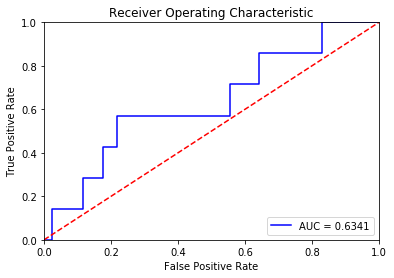

In [225]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Logistic Regression - Stratified k-fold CV

In [226]:
# build data set


# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=4) # 5-fold
classifier = LogisticRegression(max_iter = 1000, solver = 'lbfgs')


print(np.average(cross_val_score(classifier, X, y, cv=5)))
print(np.average(cross_val_score(classifier, X, y, cv=5, scoring = 'precision')))
print(np.average(cross_val_score(classifier, X, y, cv=5, scoring = 'recall')))

0.9526135878080046
0.06666666666666667
0.05


/home/parghi/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


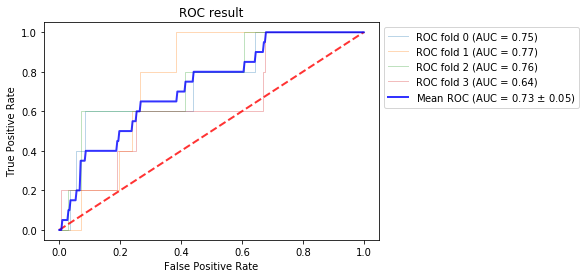

In [227]:

tprs = [] # true positive rate
aucs = []
mean_fpr = np.linspace(0, 1, 300)

plt.figure(2)
i = 0
for train, test in cv.split(X, y):
    probas_ = classifier.fit(X.values[train], y.values[train]).predict_proba(X.values[test])
    # Compute ROC curve and area the curve
    fpr, tpr, threshold = roc_curve(y.values[test], probas_[:, 1])
    # print(pd.DataFrame({"tpr_rf": tpr_rf, "fpr_rf": fpr_rf}))
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr) # calculate auc based on false positive and true positive rate
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc) )
    i += 1


# add the luck AUC line into the plot
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)

# calculate the mean AUC plot
mean_tpr = np.mean(tprs, axis=0) # mean for each 'column'
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)

pd.DataFrame({"mean_tpr": mean_tpr, "mean_fpr": mean_fpr})


std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
#plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC result')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)

# plt.show()
plt.savefig("pyton_scikit_roc.png")

## Logistic Regression - SMOTE

In [228]:
X_train.shape

(413, 49)

In [229]:
#https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=29)
os = SMOTE(random_state=29)
X_train_os, y_train_os = os.fit_sample(X_train, y_train)

X_train_os = pd.DataFrame(X_train_os)
#y_train_os = pd.DataFrame(y_train_os)
X_train_os.shape
#os_data_X,os_data_y=os.fit_sample(X_train, y_train)
#os_data_X = pd.DataFrame(data=os_data_X,columns=cols )
#os_data_y= pd.DataFrame(data=os_data_y,columns=['FU_SA'])
# we can Check the numbers of our data
#print("Length of oversampled data is ",len(os_data_X))
#print("Number of no SA in oversampled data",len(os_data_y[os_data_y['FU_SA']==0]))
#print("Number of SA",len(os_data_y[os_data_y['FU_SA']==1]))
#print("Proportion of no SA data in oversampled data is ",len(os_data_y[os_data_y['FU_SA']==0])/len(os_data_X))
#print("Proportion of SA data in oversampled data is ",len(os_data_y[os_data_y['FU_SA']==1])/len(os_data_X))


#cols = list(df.columns.values) #Make a list of all of the columns in the df
#cols.pop(cols.index('FU_SA')) #Remove b from list
#df = df[cols+['FU_SA']] #Create new dataframe with columns in the order you want

(796, 49)

In [230]:
#X=os_data_X[columns]
#y=os_data_y['FU_SA']

In [231]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train_os, y_train_os)

/home/parghi/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [232]:
y_pred_logreg_os = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.4f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.8764


In [233]:
confusion_matrix(y_test,y_pred_logreg_os)
print("Precision:", precision_score(y_test, y_pred_logreg_os))
print("Recall:", recall_score(y_test, y_pred_logreg_os))

Precision: 0.16
Recall: 0.8


In [234]:
print(classification_report(y_test, y_pred_logreg_os))

              precision    recall  f1-score   support

           0       0.99      0.88      0.93       173
           1       0.16      0.80      0.27         5

   micro avg       0.88      0.88      0.88       178
   macro avg       0.58      0.84      0.60       178
weighted avg       0.97      0.88      0.91       178



In [235]:
y_prob_logreg_os = logreg.predict_proba(X_test)
y_prob_logreg_os = y_prob_logreg_os[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_logreg_os)
roc_auc = auc(fpr, tpr)
print (roc_auc)


0.8728323699421965


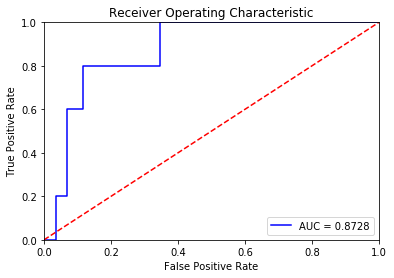

In [236]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Random Forest

In [237]:
df = pd.read_csv("SCI.csv")
cols = list(df.columns.values) #Make a list of all of the columns in the df
cols.pop(cols.index('FU_SA')) #Remove b from list
df = df[cols+['FU_SA']] #Create new dataframe with columns in the order you want
df.set_index('StudyID', inplace=True)
df.head()

,STS1,STS2,STS3,STS4,STS5,STS6,STS7,STS8,STS9,STS10,...,STS41,STS42,STS43,STS44,STS45,STS46,STS47,STS48,STS49,FU_SA
StudyID,,,,,,,,,,,,,,,,,,,,,
2031,3,3,3,3,2,2,1,2,1,1,...,1,1,1,1,1,1,1,1,1,0
2039,2,2,4,0,3,2,1,0,0,0,...,2,0,1,0,0,1,0,0,1,0
2040,1,2,4,1,0,0,0,0,0,2,...,4,3,2,4,3,3,4,4,4,0
2048,0,1,1,0,0,2,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2052,4,3,3,1,1,0,2,1,0,2,...,2,4,1,4,1,2,3,2,2,0


In [238]:
#cols = list(df.columns.values) #Make a list of all of the columns in the df
#cols.pop(cols.index('FU_SA')) #Remove FU_SA from list
#df = df[cols+['FU_SA']] #Create new dataframe with columns in the order you want

y = df.FU_SA
X = df.drop('FU_SA', axis=1)

#X = df.loc[:, df.columns != 'FU_SA']
#y = df.loc[:, df.columns == 'FU_SA']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=29)

In [239]:
correlated_features = set()  
correlation_matrix = df.corr()  

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
            
X_train.drop(labels=correlated_features, axis=1, inplace=True)  
X_test.drop(labels=correlated_features, axis=1, inplace=True)  

/usr/local/stow/python-3.6/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [240]:
rf=RandomForestClassifier(random_state=29)
rf.fit(X_train,y_train)

/home/parghi/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=29, verbose=0, warm_start=False)

In [241]:
rf_preds=rf.predict(X_test)

In [242]:
confusion_matrix(y_test,rf_preds)

array([[173,   0],
       [  5,   0]])

In [243]:
print('Accuracy of random forest classifier on test set: {:.4f}'.format(rf.score(X_test, y_test)))

Accuracy of random forest classifier on test set: 0.9719


In [244]:
print(classification_report(y_test, rf_preds))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       173
           1       0.00      0.00      0.00         5

   micro avg       0.97      0.97      0.97       178
   macro avg       0.49      0.50      0.49       178
weighted avg       0.94      0.97      0.96       178



/home/parghi/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [245]:
probs = rf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
roc_auc

0.6942196531791908

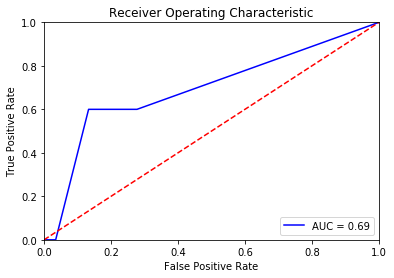

In [246]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Random Forest - SMOTE

In [247]:
df[:]

,STS1,STS2,STS3,STS4,STS5,STS6,STS7,STS8,STS9,STS10,...,STS41,STS42,STS43,STS44,STS45,STS46,STS47,STS48,STS49,FU_SA
StudyID,,,,,,,,,,,,,,,,,,,,,
2031,3,3,3,3,2,2,1,2,1,1,...,1,1,1,1,1,1,1,1,1,0
2039,2,2,4,0,3,2,1,0,0,0,...,2,0,1,0,0,1,0,0,1,0
2040,1,2,4,1,0,0,0,0,0,2,...,4,3,2,4,3,3,4,4,4,0
2048,0,1,1,0,0,2,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2052,4,3,3,1,1,0,2,1,0,2,...,2,4,1,4,1,2,3,2,2,0
2053,4,3,3,3,1,1,2,4,2,0,...,2,1,1,1,3,2,3,1,2,0
2056,4,1,2,0,2,0,0,0,1,2,...,0,0,1,0,0,0,0,0,0,0
2058,2,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2062,4,4,1,0,4,2,3,2,0,3,...,4,3,4,2,2,2,2,2,1,0


In [248]:
#https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
X = df.loc[:, df.columns != 'FU_SA']
y = df.loc[:, df.columns == 'FU_SA']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=29)

correlated_features = set()  
correlation_matrix = df.corr()  

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
            
X_train.drop(labels=correlated_features, axis=1, inplace=True)  
X_test.drop(labels=correlated_features, axis=1, inplace=True)  


columns = X_train.columns
os = SMOTE(random_state=29)
os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['FU_SA'])
# we can Check the numbers of our data
print("Length of oversampled data is ",len(os_data_X))
print("Number of no SA in oversampled data",len(os_data_y[os_data_y['FU_SA']==0]))
print("Number of SA",len(os_data_y[os_data_y['FU_SA']==1]))
print("Proportion of no SA data in oversampled data is ",len(os_data_y[os_data_y['FU_SA']==0])/len(os_data_X))
print("Proportion of SA data in oversampled data is ",len(os_data_y[os_data_y['FU_SA']==1])/len(os_data_X))

Length of oversampled data is  796
Number of no SA in oversampled data 398
Number of SA 398
Proportion of no SA data in oversampled data is  0.5
Proportion of SA data in oversampled data is  0.5


/usr/local/stow/python-3.6/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/parghi/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [249]:
rf.fit(os_data_X,os_data_y)

/usr/local/stow/python-3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=29, verbose=0, warm_start=False)

In [250]:
rf_preds = rf.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.4f}'.format(rf.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.9382


In [251]:
print(classification_report(y_test, rf_preds))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       173
           1       0.00      0.00      0.00         5

   micro avg       0.94      0.94      0.94       178
   macro avg       0.49      0.48      0.48       178
weighted avg       0.94      0.94      0.94       178



In [252]:
probs = rf.predict_proba(X_test)
preds = probs[:,1]
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, preds)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(roc_auc)

0.3225433526011561


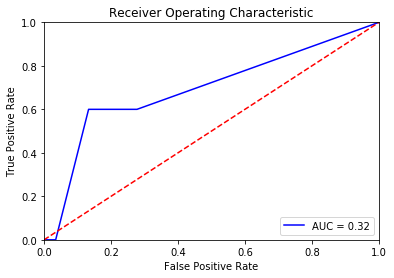

In [253]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()